
# p+Pb (5.02 TeV) vs d+Au (200 GeV): optical baseline + small-system centrality

Author: **Sabin Thapa** (Kent State University) — `sthapa3@kent.edu`

## What this notebook is for

You observed that **PbPb/AuAu** show obvious centrality-dependent geometric changes in the initial energy density,
but **pPb/dAu** look “too similar” across centrality.

This notebook shows *why* that happens and how to do it correctly:

1) **Optical Glauber (b-percentile)** centrality — clean baseline geometry  
2) **MC Glauber (S-percentile)** centrality — realistic for small systems (multiplicity-like)  
3) **aHydro tilted initial energy density** ε(x,y,ς): what changes with centrality (amplitude vs shape)

---

## Key physics takeaways (read once)

### 1) Peak-normalization erases centrality dependence by construction
If you plot
\[
\frac{\epsilon(x,y,\varsigma=0)}{\epsilon_{\max}},
\]
then all centralities have the same maximum (1), so the **only** remaining information is *shape*.

In small systems the shape is largely set by the **projectile size** (proton or deuteron),
so peak-normalized maps look very similar.

### 2) In pA, the transverse *shape* is proton-dominated
For p+Pb, changing impact parameter mostly changes the *local target thickness* the proton overlaps with.
The proton profile remains proton-like over a wide range of b → small shape changes.

### 3) In dA, orientation fluctuations matter (and are washed out by averaging)
A deuteron is two nucleons separated by a few fm.
If you use an **orientation-averaged** deuteron thickness \(T_d\), you suppress the two-hot-spot structure.

### 4) Small-system centrality should be S-based (multiplicity-like), not b-based
For pA/dA, experimental “centrality” is usually defined by multiplicity.
That requires event-by-event fluctuations (MC Glauber with Gamma weights or TRENTo-like models).


In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path('..').resolve()))


# Imports
import numpy as np
import matplotlib.pyplot as plt

from src.plotting import set_pub_style, style_ax
from src.physics import DEFAULT_SIGMA_NN
from src.geometry import nucleus_from_name, GeneralizedGaussianProton, DeuteronThickness
from src.glauber_optical import OpticalGlauber, make_grid2d, integrate_2d
from src.initial_ahydro import TiltedParams, epsilon_tilted_slice, rho_longitudinal, g_tilt
from src.glauber_mc import MCGlauberConfig, run_mc_glauber, centrality_bins_from_S

set_pub_style()


In [2]:

# Build common grids
grid = make_grid2d(xmax=12, nx=241, ymax=12, ny=241)
zeta = np.linspace(-10.0, 10.0, 801)

CENT = np.arange(0, 101, 10)



## Define systems (paper-like defaults)

- p+Pb 5.02 TeV: σNN ≈ 67.6 mb (commonly used; override if your run card differs)
- d+Au 200 GeV: σNN ≈ 42 mb

For d+Au we build an orientation-averaged deuteron thickness using a Hulthén sampler.


In [3]:

# Objects
Pb = nucleus_from_name("Pb")
Au = nucleus_from_name("Au")
p_profile = GeneralizedGaussianProton()
d_profile = DeuteronThickness(p_profile, n_orientations=1200, seed=7)  # increase if you want even smoother

sigma_pPb = DEFAULT_SIGMA_NN.sigma_mb(5020.0)
sigma_dAu = DEFAULT_SIGMA_NN.sigma_mb(200.0)

# Optical models
opt_pPb = OpticalGlauber("pA", sigmaNN_mb=sigma_pPb, nuc_target=Pb, proton_projectile=p_profile)
opt_dAu = OpticalGlauber("dA", sigmaNN_mb=sigma_dAu, nuc_target=Au, deuteron_projectile=d_profile)

print("σNN(pPb@5.02) =", sigma_pPb, "mb")
print("σNN(dAu@200)  =", sigma_dAu, "mb")


σNN(pPb@5.02) = 67.6 mb
σNN(dAu@200)  = 42.0 mb



## Optical baseline: Npart(b), Ncoll(b) and b-percentile centrality tables

This is the *cleanest* geometry-only baseline.
But for small systems, remember: this is **not** the same as experimental centrality.


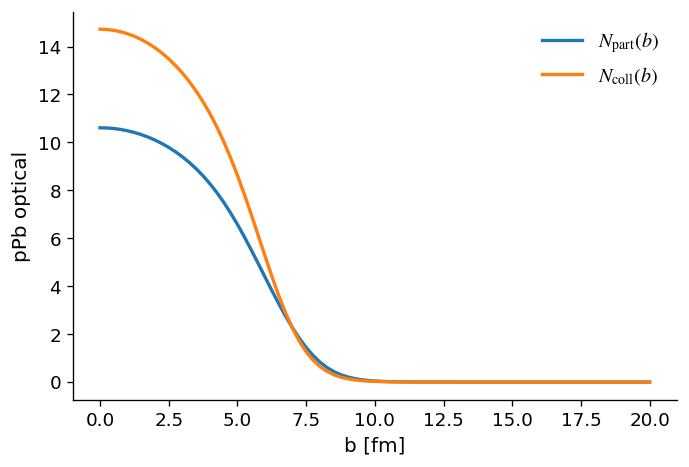

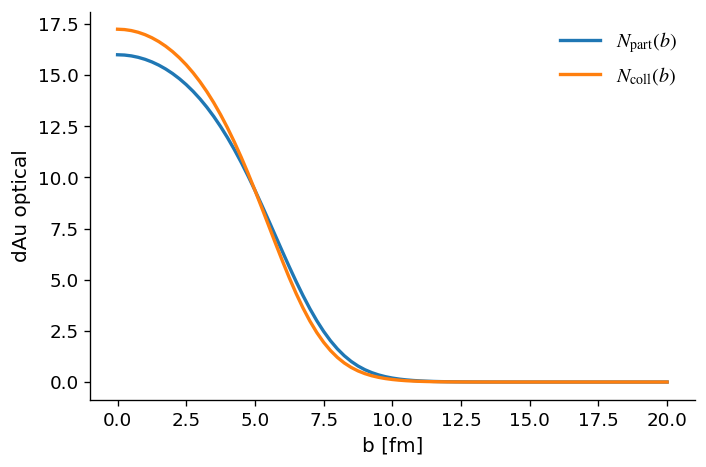

pPb <b> per decile: [1.509 2.895 3.89  4.628 5.256 5.877 6.377 6.874 7.485 8.691]
dAu <b> per decile: [1.675 3.279 4.257 5.006 5.755 6.377 6.876 7.495 8.234 9.639]


In [4]:

tab_pPb = opt_pPb.centrality_table(grid=grid, bmax=20.0, db=0.25, cent_edges=CENT)
tab_dAu = opt_dAu.centrality_table(grid=grid, bmax=20.0, db=0.25, cent_edges=CENT)

def plot_np_nc(tab, label):
    fig, ax = plt.subplots()
    ax.plot(tab["b_vals"], tab["Npart"], label=r"$N_{\mathrm{part}}(b)$")
    ax.plot(tab["b_vals"], tab["Ncoll"], label=r"$N_{\mathrm{coll}}(b)$")
    ax.set_xlabel("b [fm]")
    ax.set_ylabel(label)
    ax.legend()
    style_ax(ax)
    plt.show()

plot_np_nc(tab_pPb, "pPb optical")
plot_np_nc(tab_dAu, "dAu optical")

print("pPb <b> per decile:", np.round(tab_pPb["b_mean"], 3))
print("dAu <b> per decile:", np.round(tab_dAu["b_mean"], 3))



## Tilted longitudinal structure (centrality independent in this model)

In the parameterizations used here, \( \rho(\varsigma) \) and \( g(\varsigma) \) depend on √s, Δ, σ only —
not on b (centrality).


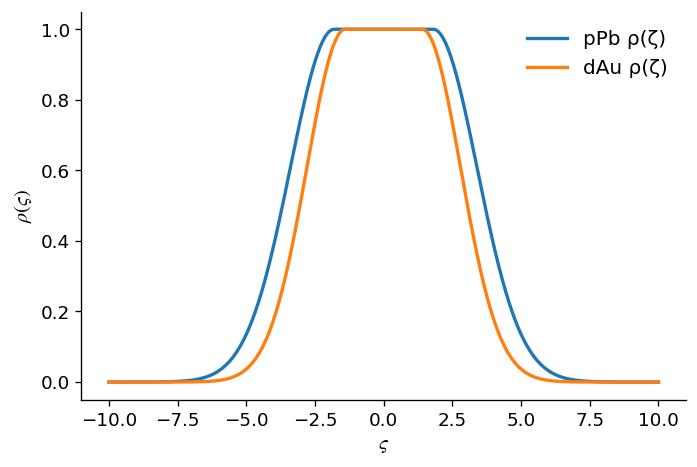

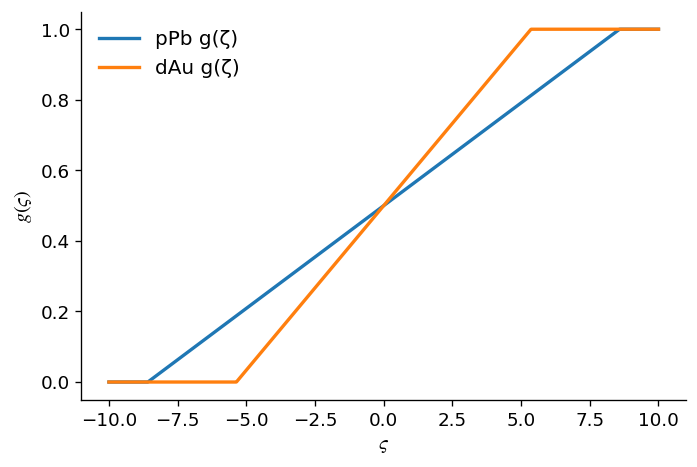

In [5]:

# Longitudinal shapes (just to confirm)
z = np.linspace(-10, 10, 1201)

# parameters (representative; adjust to match your run cards)
pars_pPb = TiltedParams(sNN_GeV=5020.0, chi=0.15, Delta_zeta=1.8, sigma_zeta=1.6)
pars_dAu = TiltedParams(sNN_GeV=200.0,  chi=0.15, Delta_zeta=1.4, sigma_zeta=1.4)

fig, ax = plt.subplots()
ax.plot(z, rho_longitudinal(z, pars_pPb.Delta_zeta, pars_pPb.sigma_zeta), label="pPb ρ(ζ)")
ax.plot(z, rho_longitudinal(z, pars_dAu.Delta_zeta, pars_dAu.sigma_zeta), label="dAu ρ(ζ)")
ax.set_xlabel(r"$\varsigma$")
ax.set_ylabel(r"$\rho(\varsigma)$")
ax.legend()
style_ax(ax)
plt.show()

fig, ax = plt.subplots()
ax.plot(z, g_tilt(z, yN=np.log((2*5020.0)/(0.9382720813+0.9395654133))), label="pPb g(ζ)")
ax.plot(z, g_tilt(z, yN=np.log((2*200.0)/(0.9382720813+0.9395654133))),  label="dAu g(ζ)")
ax.set_xlabel(r"$\varsigma$")
ax.set_ylabel(r"$g(\varsigma)$")
ax.legend()
style_ax(ax)
plt.show()



## Energy density at midrapidity ζ=0 across centrality (optical b-percentiles)

We show two normalizations:

1) **Absolute (fixed scale across bins)** — we normalize all centralities by the *0–10% peak*.
   This shows amplitude differences.

2) **Peak-normalized per bin** — highlights only the shape (expected to be similar in pA).


pPb: fixed-scale (amplitude visible)


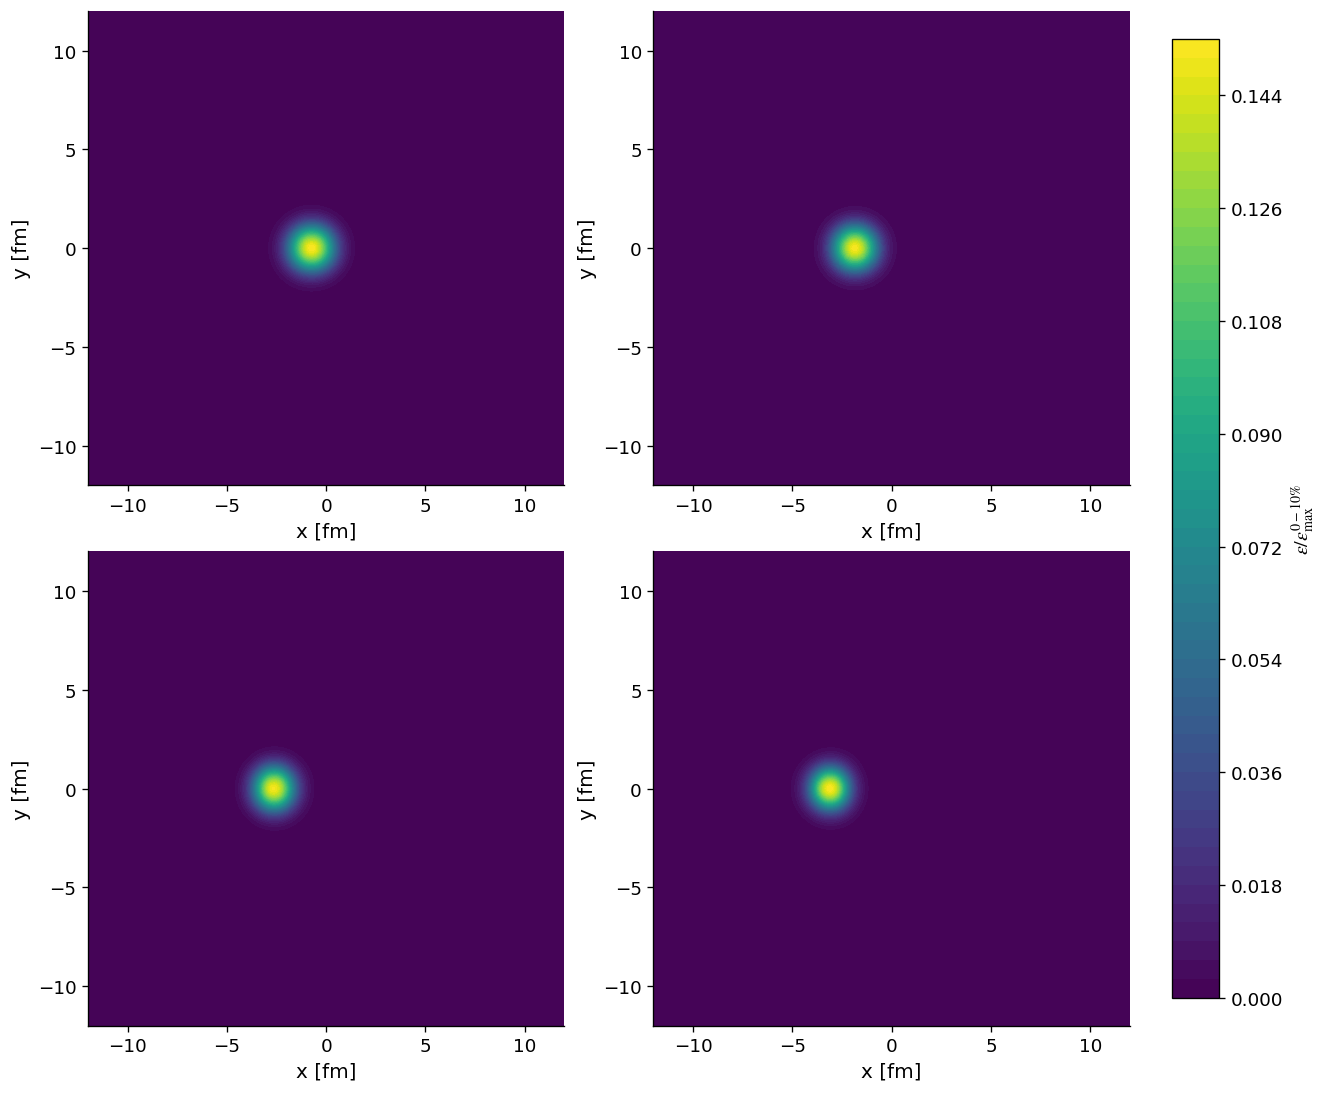

pPb: peak-normalized (shape only)


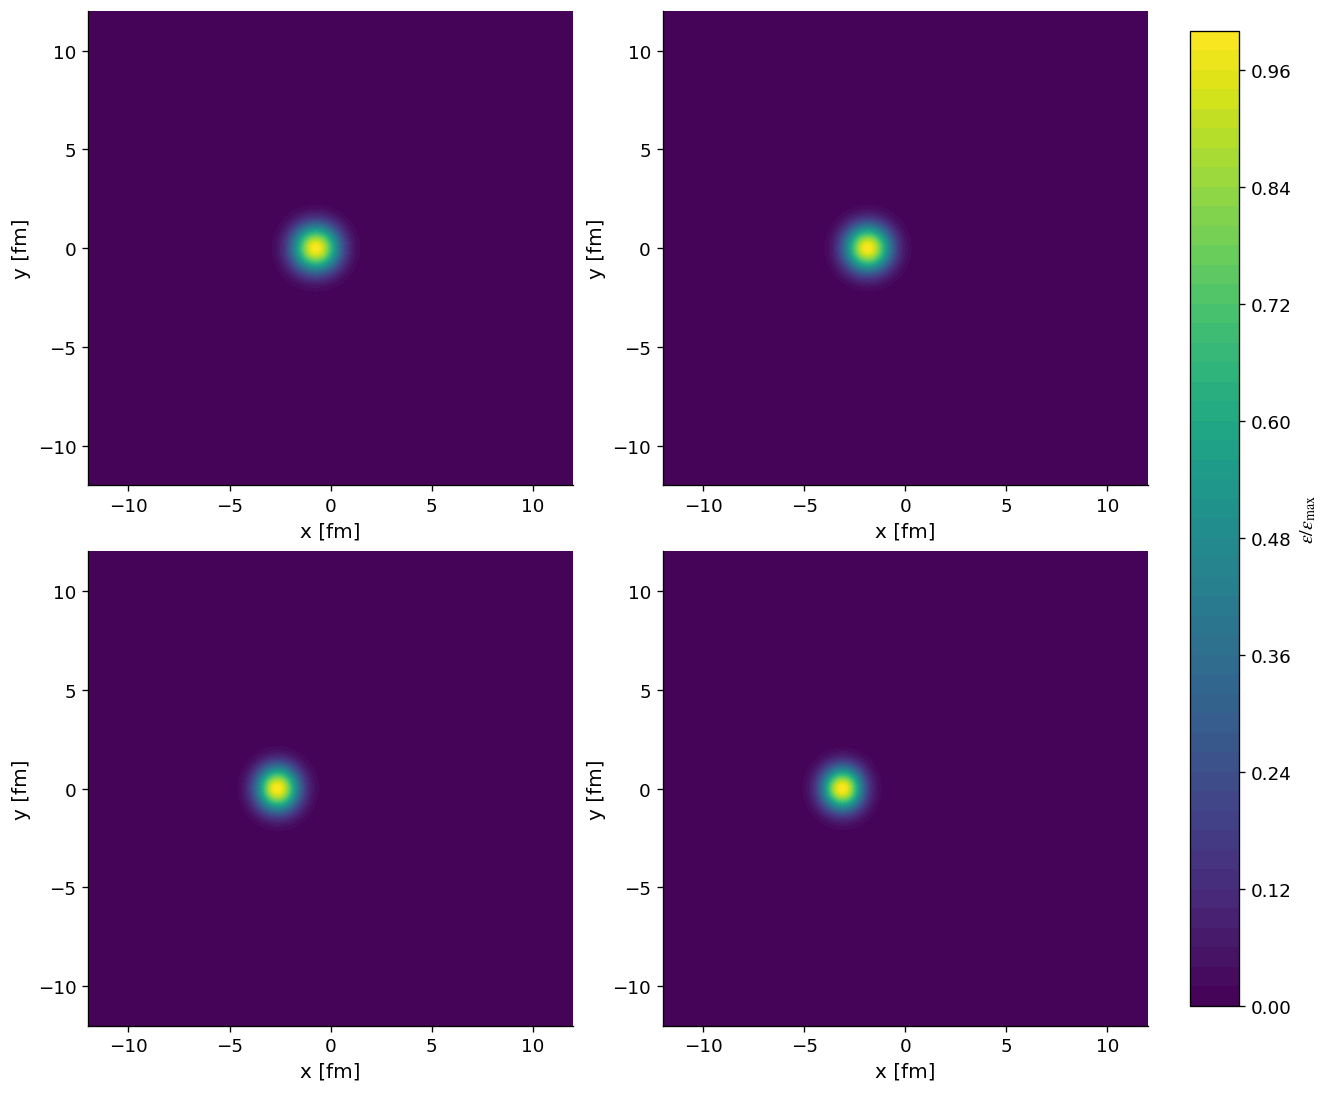

dAu: fixed-scale (amplitude visible)


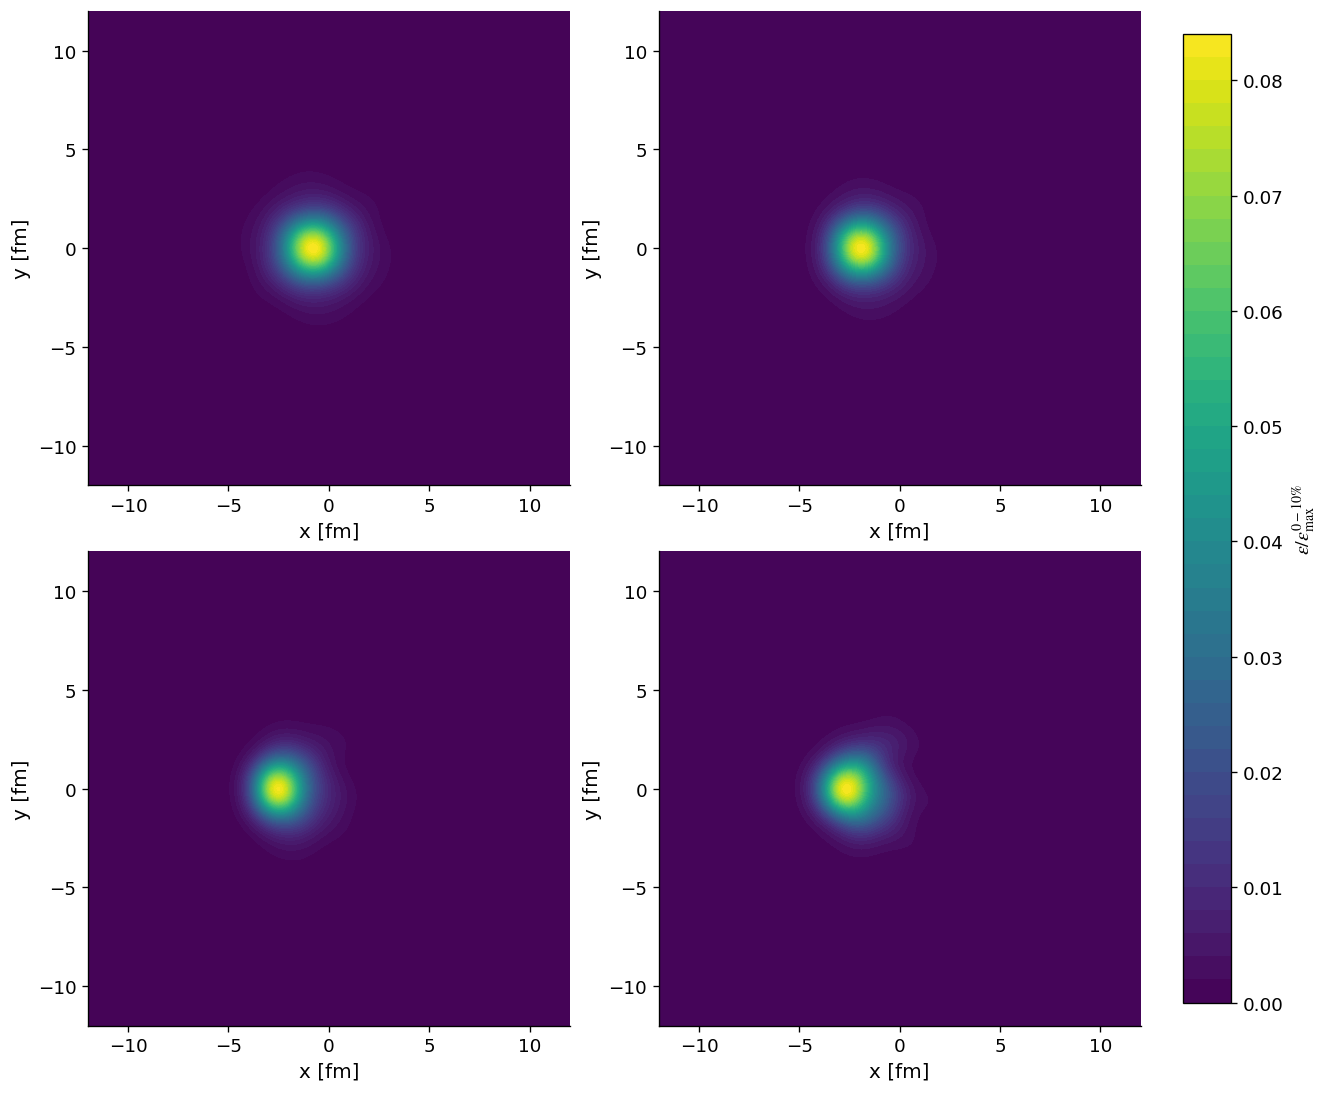

dAu: peak-normalized (shape only)


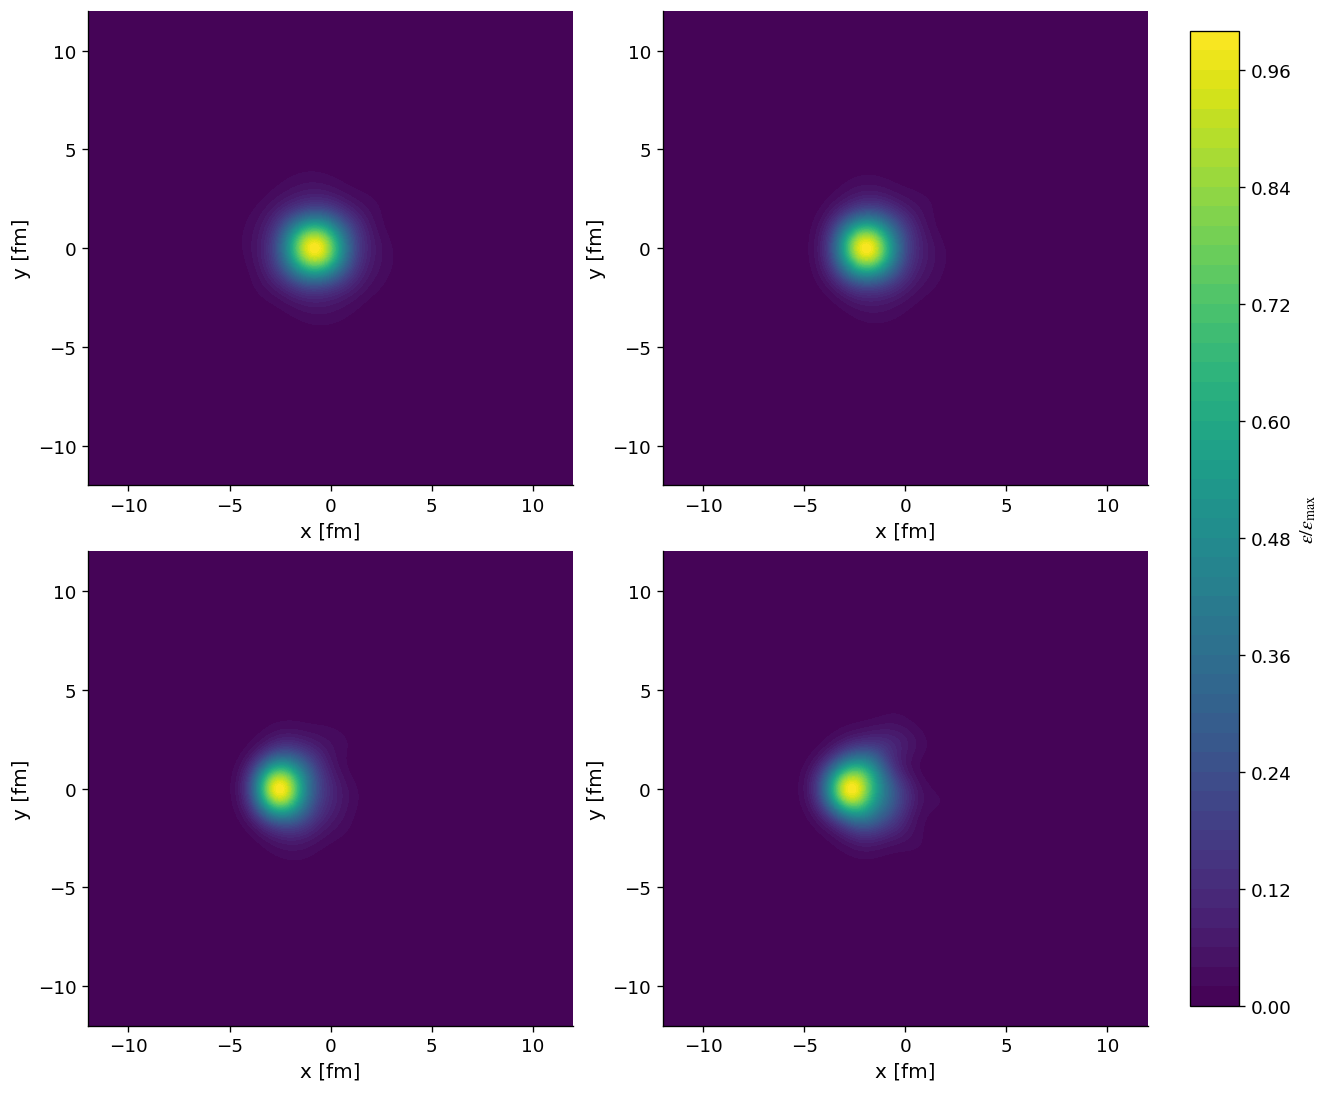

In [6]:

def eps_midrapidity(opt: OpticalGlauber, b: float, pars: TiltedParams):
    Wp, Wt, C = opt.profiles_xy(b, grid)
    eps = epsilon_tilted_slice(0.0, zeta, Wp, Wt, C, pars)
    return eps

def show_selected(opt, tab, pars, label, bins=[0,2,5,8], mode="fixed"):
    # bins are decile indices: 0->0-10%, 2->20-30%, etc.
    eps_list = []
    for i in bins:
        b = tab["b_mean"][i]
        eps_list.append(eps_midrapidity(opt, b, pars))

    # reference peak from the first bin (typically 0-10%)
    ref = np.max(eps_list[0])

    fig, axs = plt.subplots(2, 2, figsize=(11, 9), constrained_layout=True)
    axs = axs.flatten()
    last = None

    for ax, i, eps in zip(axs, bins, eps_list):
        if mode == "fixed":
            Z = eps / ref
            cbar_label = r"$\epsilon/\epsilon^{0-10\%}_{\max}$"
        else:
            Z = eps / np.max(eps)
            cbar_label = r"$\epsilon/\epsilon_{\max}$"

        last = ax.contourf(grid.X, grid.Y, Z, levels=50)
        ax.set_xlabel("x [fm]")
        ax.set_ylabel("y [fm]")
        ax.legend([f"{label}  {CENT[i]}–{CENT[i+1]}%   <b>={tab['b_mean'][i]:.2f} fm"], loc="upper right")
        style_ax(ax)

    fig.colorbar(last, ax=axs, fraction=0.046, pad=0.04, label=cbar_label)
    plt.show()

print("pPb: fixed-scale (amplitude visible)")
show_selected(opt_pPb, tab_pPb, pars_pPb, "pPb 5.02", mode="fixed")

print("pPb: peak-normalized (shape only)")
show_selected(opt_pPb, tab_pPb, pars_pPb, "pPb 5.02", mode="peak")

print("dAu: fixed-scale (amplitude visible)")
show_selected(opt_dAu, tab_dAu, pars_dAu, "dAu 200", mode="fixed")

print("dAu: peak-normalized (shape only)")
show_selected(opt_dAu, tab_dAu, pars_dAu, "dAu 200", mode="peak")



### Quantify what actually changes with centrality in pA/dA (optical)

For small systems, the **peak value** and the **integrated energy density** change significantly with b,
even if the shape looks similar when peak-normalized.


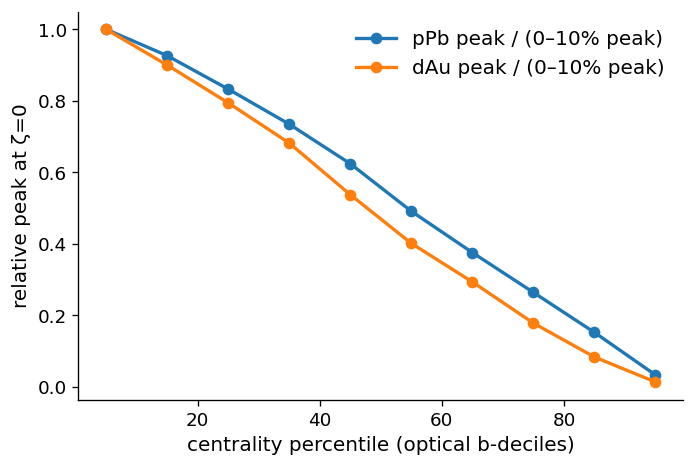

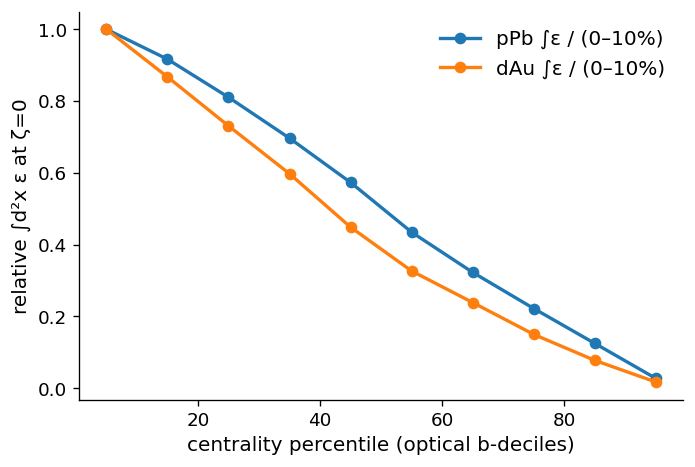

In [7]:

def peak_and_integral(opt: OpticalGlauber, tab, pars: TiltedParams):
    peaks = []
    integrals = []
    for b in tab["b_mean"]:
        eps = eps_midrapidity(opt, float(b), pars)
        peaks.append(float(np.max(eps)))
        integrals.append(float(integrate_2d(eps, grid)))
    return np.array(peaks), np.array(integrals)

pk_pPb, I_pPb = peak_and_integral(opt_pPb, tab_pPb, pars_pPb)
pk_dAu, I_dAu = peak_and_integral(opt_dAu, tab_dAu, pars_dAu)

cent_mid = 0.5 * (CENT[:-1] + CENT[1:])

fig, ax = plt.subplots()
ax.plot(cent_mid, pk_pPb / pk_pPb[0], marker="o", label="pPb peak / (0–10% peak)")
ax.plot(cent_mid, pk_dAu / pk_dAu[0], marker="o", label="dAu peak / (0–10% peak)")
ax.set_xlabel("centrality percentile (optical b-deciles)")
ax.set_ylabel("relative peak at ζ=0")
ax.legend()
style_ax(ax)
plt.show()

fig, ax = plt.subplots()
ax.plot(cent_mid, I_pPb / I_pPb[0], marker="o", label="pPb ∫ε / (0–10%)")
ax.plot(cent_mid, I_dAu / I_dAu[0], marker="o", label="dAu ∫ε / (0–10%)")
ax.set_xlabel("centrality percentile (optical b-deciles)")
ax.set_ylabel("relative ∫d²x ε at ζ=0")
ax.legend()
style_ax(ax)
plt.show()



## dAu accuracy: convergence of orientation averaging

If `n_orientations` is too small, your dAu profiles can be noisy or biased.
This cell shows convergence of midline slices at fixed b.


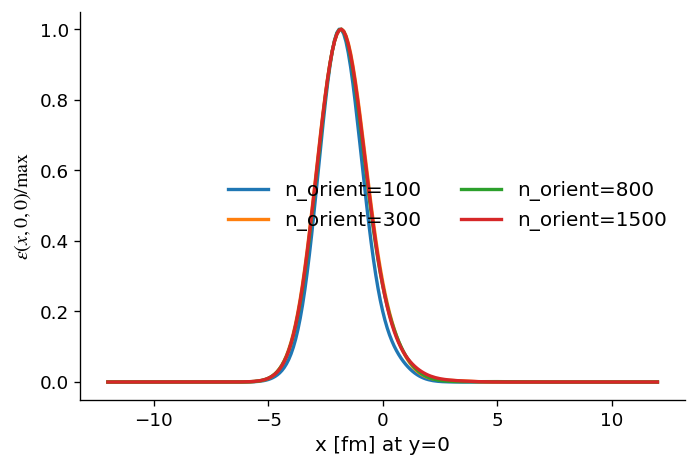

Reference: 1500
n= 100  max|Δ| = 9.461e-02
n= 300  max|Δ| = 1.055e-02
n= 800  max|Δ| = 1.394e-02


In [8]:

from src.geometry import HulthenParams

def dAu_convergence(n_list=(100, 300, 800, 1500), b=4.0):
    ref_curve = None
    ref_n = None
    iy0 = np.argmin(np.abs(grid.y - 0.0))

    fig, ax = plt.subplots()
    for n in n_list:
        dtmp = DeuteronThickness(p_profile, n_orientations=int(n), seed=7, hulthen=HulthenParams())
        opt_tmp = OpticalGlauber("dA", sigmaNN_mb=sigma_dAu, nuc_target=Au, deuteron_projectile=dtmp)
        eps = eps_midrapidity(opt_tmp, b, pars_dAu)
        curve = eps[iy0, :]
        curve = curve / np.max(curve)
        ax.plot(grid.x, curve, label=f"n_orient={n}")
        if n == max(n_list):
            ref_curve = curve.copy()
            ref_n = n

    ax.set_xlabel("x [fm] at y=0")
    ax.set_ylabel(r"$\epsilon(x,0,0)/\max$")
    ax.legend(ncol=2)
    style_ax(ax)
    plt.show()

    # quantify max deviation vs reference
    print("Reference:", ref_n)
    for n in n_list[:-1]:
        dtmp = DeuteronThickness(p_profile, n_orientations=int(n), seed=7, hulthen=HulthenParams())
        opt_tmp = OpticalGlauber("dA", sigmaNN_mb=sigma_dAu, nuc_target=Au, deuteron_projectile=dtmp)
        eps = eps_midrapidity(opt_tmp, b, pars_dAu)
        curve = eps[iy0, :]
        curve = curve / np.max(curve)
        print(f"n={n:4d}  max|Δ| = {np.max(np.abs(curve-ref_curve)):.3e}")

dAu_convergence()



## MC Glauber: entropy-based centrality (multiplicity-like)

This is the important small-system point:

- With MC + Gamma weights, centrality is defined by **S quantiles** (largest S = most central).
- The distribution of b inside an S-bin is broad.
- Therefore “0–10%” in small systems does **not** correspond to a narrow b range.

We show:
- S distribution
- b distributions for a few S-centrality classes


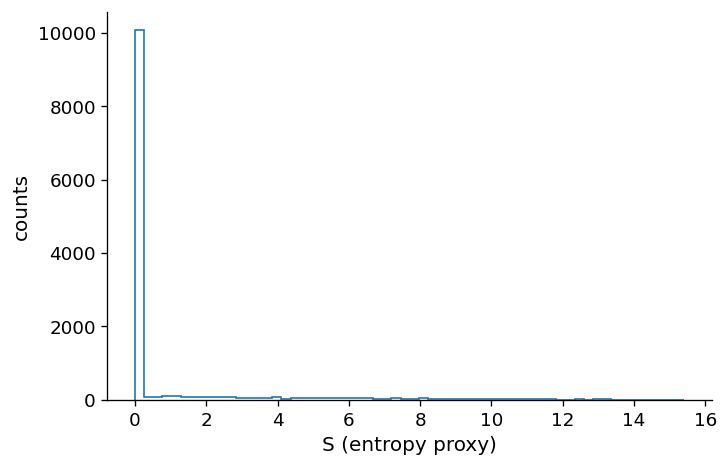

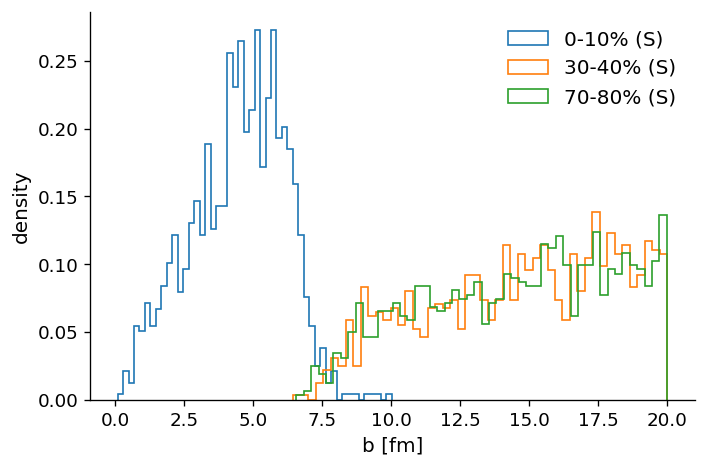

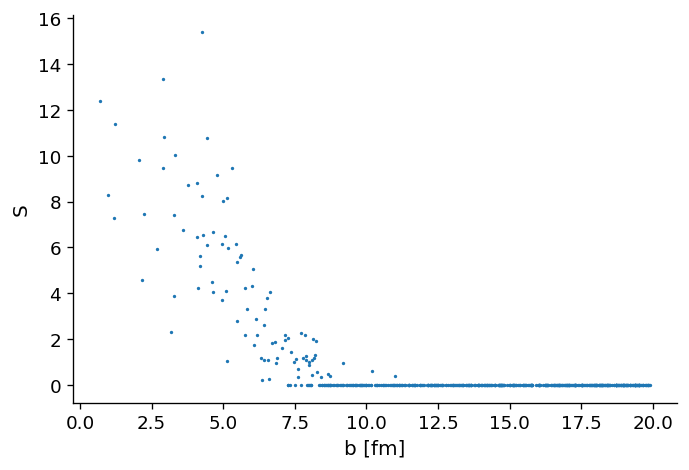

In [9]:

# MC for pPb (fast; can increase n_events if desired)
cfg_mc_pPb = MCGlauberConfig(kind="pA", sNN_GeV=5020.0, sigmaNN_mb=sigma_pPb, projectile="p", target="Pb", chi=0.15,
                            use_gamma_weights=True, gamma_k=1.0, bmax=20.0)

mc = run_mc_glauber(cfg_mc_pPb, n_events=12000, seed=123)

S = mc["S"]
b_evt = mc["b"]

# centrality bins by S
bins = centrality_bins_from_S(S, CENT)

fig, ax = plt.subplots()
ax.hist(S, bins=60, histtype="step")
ax.set_xlabel("S (entropy proxy)")
ax.set_ylabel("counts")
style_ax(ax)
plt.show()

# Show b distributions for selected centralities
sel = [(0,10),(30,40),(70,80)]
fig, ax = plt.subplots()
for (c0,c1) in sel:
    idx = bins["bins"][int(c0/10)]
    ax.hist(b_evt[idx], bins=50, histtype="step", density=True, label=f"{c0}-{c1}% (S)")
ax.set_xlabel("b [fm]")
ax.set_ylabel("density")
ax.legend()
style_ax(ax)
plt.show()

# Correlation check: b vs S
fig, ax = plt.subplots()
ax.plot(b_evt[::20], S[::20], ".", markersize=2)
ax.set_xlabel("b [fm]")
ax.set_ylabel("S")
style_ax(ax)
plt.show()


## Centrality classes in pPb LHC and dAu RHIC